<a href="https://colab.research.google.com/github/athiraa12/Smart-login-risk-score-generator/blob/main/Smart_Login_Risk_Score_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 import pandas as pd
 path="/content/suspicious_login_activity.csv"
 df= pd.read_csv(path)
 df.head()

,user_id,timestamp,country,device,ip_address,login_success,is_anomaly
0,user_41,2025-07-10 14:29:00,India,Android Phone,192.168.1.59,1,0
1,user_48,2025-06-01 02:19:00,India,iPhone,192.168.1.9,1,0
2,user_39,2025-07-18 07:43:00,India,iPad,172.16.0.181,1,0
3,user_38,2025-06-25 09:58:00,Brazil,Windows PC,192.168.1.180,1,0
4,user_14,2025-06-20 02:23:00,India,iPhone,192.168.1.93,1,0


In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(by= ['user_id','timestamp'], inplace=True)

df['hour_of_day'] = df['timestamp'].dt.hour
df['is_weekend'] = df['timestamp'].dt.weekday> 5
df['odd_hour'] = df['hour_of_day'].apply(lambda x: x < 6 or x > 22)

df.head()

,user_id,timestamp,country,device,ip_address,login_success,is_anomaly,hour_of_day,is_weekend,odd_hour
1421,user_1,2025-05-12 01:03:00,Brazil,Unknown Device,172.16.0.53,1,1,1,False,True
1345,user_1,2025-05-14 13:27:00,USA,iPhone,192.168.1.238,1,0,13,False,False
492,user_1,2025-05-17 23:37:00,USA,Linux Desktop,10.0.0.30,1,0,23,False,True
1379,user_1,2025-05-22 16:42:00,India,Linux Desktop,10.0.0.85,1,0,16,False,False
597,user_1,2025-05-23 08:29:00,Germany,Windows PC,172.16.0.151,1,0,8,False,False


In [ ]:
df['device_change'] = df.groupby('user_id')['device'].transform(lambda x : x != x.shift())
df['location_change'] = df.groupby('user_id')['country'].transform(lambda x: x != x.shift())
df['ip_change'] = df.groupby('user_id')['ip_address'].transform(lambda x: x != x.shift())
df.head()

,user_id,timestamp,country,device,ip_address,login_success,is_anomaly,hour_of_day,is_weekend,odd_hour,device_change,location_change,ip_change
1421,user_1,2025-05-12 01:03:00,Brazil,Unknown Device,172.16.0.53,1,1,1,False,True,True,True,True
1345,user_1,2025-05-14 13:27:00,USA,iPhone,192.168.1.238,1,0,13,False,False,True,True,True
492,user_1,2025-05-17 23:37:00,USA,Linux Desktop,10.0.0.30,1,0,23,False,True,True,False,True
1379,user_1,2025-05-22 16:42:00,India,Linux Desktop,10.0.0.85,1,0,16,False,False,False,True,True
597,user_1,2025-05-23 08:29:00,Germany,Windows PC,172.16.0.151,1,0,8,False,False,True,True,True


In [ ]:
df['risk_score'] = (
    df['device_change'].astype(int) +
    df['ip_change'].astype(int) +
    df['location_change'].astype(int) +
    df['odd_hour'].astype(int) +
    df['is_weekend'].astype(int)
)
df['predicted_anomaly'] = df['risk_score'] >= 3

df.head()

,user_id,timestamp,country,device,ip_address,login_success,is_anomaly,hour_of_day,is_weekend,odd_hour,device_change,location_change,ip_change,risk_score,predicted_anomaly
1421,user_1,2025-05-12 01:03:00,Brazil,Unknown Device,172.16.0.53,1,1,1,False,True,True,True,True,4,True
1345,user_1,2025-05-14 13:27:00,USA,iPhone,192.168.1.238,1,0,13,False,False,True,True,True,3,True
492,user_1,2025-05-17 23:37:00,USA,Linux Desktop,10.0.0.30,1,0,23,False,True,True,False,True,3,True
1379,user_1,2025-05-22 16:42:00,India,Linux Desktop,10.0.0.85,1,0,16,False,False,False,True,True,2,False
597,user_1,2025-05-23 08:29:00,Germany,Windows PC,172.16.0.151,1,0,8,False,False,True,True,True,3,True


In [ ]:

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(df['is_anomaly'], df['predicted_anomaly']))
print(classification_report(df['is_anomaly'], df['predicted_anomaly']))

[[419 967]
 [  0 114]]
              precision    recall  f1-score   support

           0       1.00      0.30      0.46      1386
           1       0.11      1.00      0.19       114

    accuracy                           0.36      1500
   macro avg       0.55      0.65      0.33      1500
weighted avg       0.93      0.36      0.44      1500



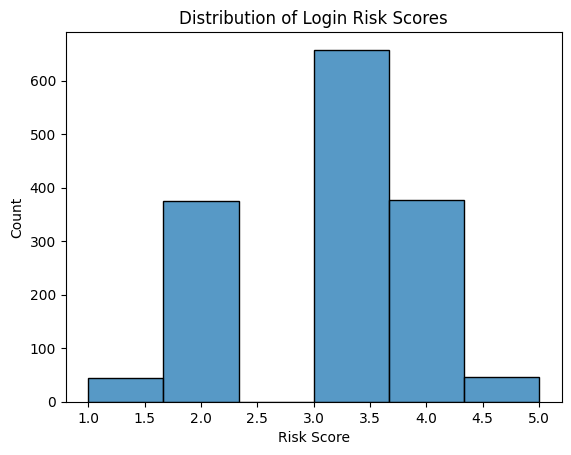

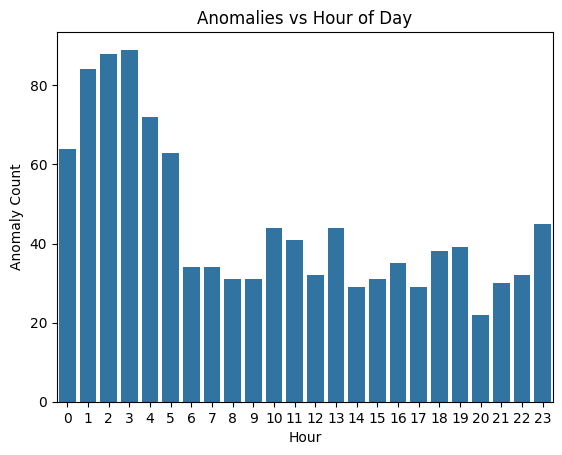

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Risk Score Distribution
sns.histplot(df['risk_score'], bins=6, kde=False)
plt.title("Distribution of Login Risk Scores")
plt.xlabel("Risk Score")
plt.ylabel("Count")
plt.show()

# Anomalies by Hour of Day
sns.countplot(data=df[df['predicted_anomaly']==True], x='hour_of_day')
plt.title("Anomalies vs Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Anomaly Count")
plt.show()


In [ ]:
df.to_csv("suspicious_login_predictions.csv", index=False)


In [ ]:
features = ['hour_of_day', 'is_weekend', 'device_change', 'ip_change', 'location_change', 'odd_hour', 'risk_score']
target = 'is_anomaly'
#train-test-split
from sklearn.model_selection import train_test_split
X= df[features].astype(int)
y= df[target].astype(int)
df[target] = df[target].astype(int)

X_test, X_train, y_test, y_train = train_test_split(X,y , test_size=0.3, random_state=42)

In [ ]:
#train a classifier(Random Forest)
from sklearn.ensemble import RandomForestRegressor
model= RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
#Evalute
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
predictions = (model.predict(X_test) > 0.5).astype(int)
print(np.unique(predictions))  # Should be [0 1]
print(predictions[:10])
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))


[0 1]
[0 0 0 0 0 0 0 0 0 0]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       973
           1       0.38      0.18      0.25        77

    accuracy                           0.92      1050
   macro avg       0.66      0.58      0.60      1050
weighted avg       0.90      0.92      0.90      1050

[[950  23]
 [ 63  14]]


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Create a model with balanced class weight
model = LogisticRegression(class_weight='balanced', max_iter=1000)

# 2. Fit the model
model.fit(X_train, y_train)

# 3. Predict
predictions = model.predict(X_test)
probs = model.predict_proba(X_test)[:, 1]  # For ROC-AUC

# 4. Evaluation
print("Unique predictions:", np.unique(predictions))
print("Sample predictions:", predictions[:10])
print("Prediction type:", type(predictions[0]))

print("\n📄 Classification Report:")
print(classification_report(y_test, predictions))

print("\n🧾 Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("\n📊 ROC-AUC Score:")
print(roc_auc_score(y_test, probs))


Unique predictions: [0 1]
Sample predictions: [0 0 0 0 0 1 0 0 0 0]
Prediction type: <class 'numpy.int64'>

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90       973
           1       0.29      0.87      0.44        77

    accuracy                           0.84      1050
   macro avg       0.64      0.85      0.67      1050
weighted avg       0.94      0.84      0.87      1050


🧾 Confusion Matrix:
[[810 163]
 [ 10  67]]

📊 ROC-AUC Score:
0.9131218216521402


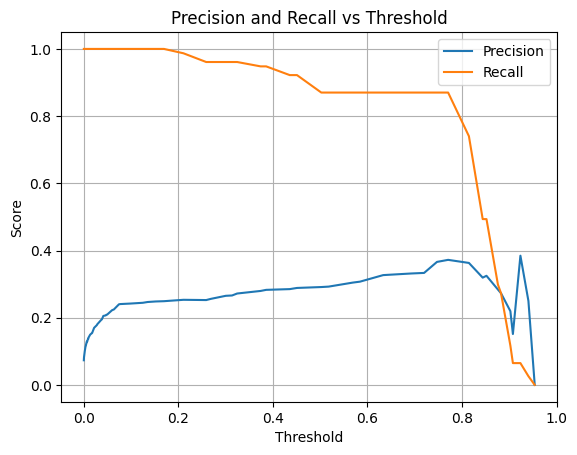

In [ ]:
# Correct version
y_scores = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot
import matplotlib.pyplot as plt

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Predict probabilities and adjust threshold
risk_scores = model.predict_proba(X_test)[:, 1]
optimal_threshold = 0.65  # <-- Adjust this based on your precision-recall curve
y_pred_adjusted = (risk_scores > optimal_threshold).astype(int)

# Step 2: Evaluate the adjusted predictions
print("📄 Classification Report (Threshold = {:.2f}):".format(optimal_threshold))
print(classification_report(y_test, y_pred_adjusted))
print("🧾 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_adjusted))

# Step 3: Prepare the test DataFrame with risk scores
df_test = X_test.copy()
df_test["actual_label"] = y_test.values
df_test["risk_score"] = (risk_scores * 100).round(2)
df_test["predicted_label"] = y_pred_adjusted

# Step 4: Show Top 10 High-Risk Login Attempts
print("\n🔝 Top 10 Most Suspicious Logins:")
print(df_test.sort_values(by="risk_score", ascending=False).head(10))

# Save as CSV
df_test.to_csv("scored_login_predictions.csv", index=False)



📄 Classification Report (Threshold = 0.65):
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       973
           1       0.33      0.87      0.48        77

    accuracy                           0.86      1050
   macro avg       0.66      0.87      0.70      1050
weighted avg       0.94      0.86      0.89      1050

🧾 Confusion Matrix:
[[838 135]
 [ 10  67]]

🔝 Top 10 Most Suspicious Logins:
      hour_of_day  is_weekend  device_change  ip_change  location_change  \
1391            0           1              1          1                1   
1183            0           1              1          1                1   
422             0           1              1          1                1   
568             0           1              1          1                1   
46              0           1              1          1                1   
274             1           1              1          1                1   
26              1   

In [ ]:
df_test.to_csv("scored_login_predictions.csv", index=False)
from google.colab import files
files.download("scored_login_predictions.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>